# What's this guitar...?

A quick first notebook to distinguish between 11 guitar models from Gibson and Fender... All data downloaded and cleaned using [fastclass](https://github.com/cwerner/fastclass). The full dataset consists of 27 classes, but cleaning them is quite time consuming... Will rerun when all are inspected...

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
__version__

'1.0.26'

In [3]:
import pathlib
import os
import tarfile
from io import BytesIO

In [4]:
# pull data
DROPBOX_URL = "https://www.dropbox.com/s/2a9oboj6dcoykt0/guitars.tgz?dl=1"

p = pathlib.Path.cwd()/'data'
p.mkdir(parents=True, exist_ok=True)

def download_and_untar(url, **kw):
    # modified after https://gist.github.com/ptomulik/2d988ae760b992da62f8
    cpath = pathlib.Path.cwd()
    os.chdir(cpath/'data')   

    try:                from urllib.request import urlopen
    except ImportError: from urllib import urlopen
    # Options
    try:                strip_components = kw['strip_components']
    except KeyError:    strip_components = 0
    # Download the tar file
    tar = tarfile.open(fileobj = BytesIO(urlopen(url).read()))
    members = [m for m in tar.getmembers() if len(m.name.split(os.sep)) > strip_components]
    if strip_components > 0:
        for m in members:                                                                               
            m.name = os.path.join(*(m.name.split(os.sep)[strip_components:]))
    tar.extractall(members = members)
    tar.close()
    os.chdir(cpath)

download_and_untar(DROPBOX_URL, strip_components = 0)

In [5]:
classes = sorted([x.name for x in (pathlib.Path.cwd()/'data/guitars').iterdir()])

In [6]:
path = pathlib.Path.cwd()/'tmp' # temporary model states

In [7]:
# split data into train, val sets
np.random.seed(42)
src = (ImageItemList.from_folder(pathlib.Path.cwd()/'data/guitars')
           .random_split_by_pct()
           .label_from_folder(classes=classes))

In [8]:
def get_data(src, sz=224, bs=64):
    """get new databunch with requested resolution"""
    return (src.transform(get_transforms(do_flip=False), size=sz)
               .databunch(bs=bs)).normalize(imagenet_stats)

In [9]:
data = get_data(src, sz=299, bs=32)

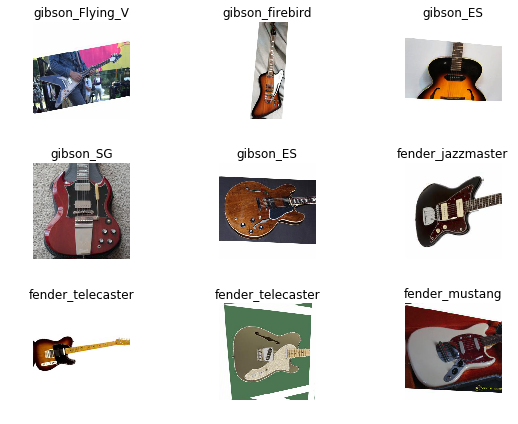

In [10]:
# inspect some images
data.show_batch(rows=3, figsize=(8,6))

# A first model (ResNet34, px=224)
## Training 

We start small. Picture size 224x224px. We can therefore use a larger batch size (64).

In [11]:
data = get_data(src, sz=224, bs=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


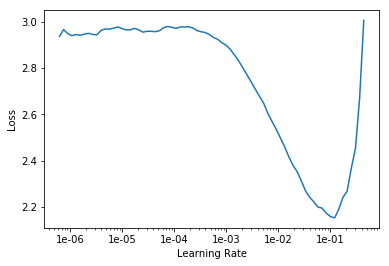

In [12]:
learn = create_cnn(data, models.resnet34, path='.', metrics=error_rate)
learn.lr_find(); 
learn.recorder.plot()

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:34
epoch  train_loss  valid_loss  error_rate
1      0.928203    0.450700    0.162353    (00:57)
2      0.536406    0.311858    0.098824    (00:54)
3      0.347128    0.200679    0.065882    (00:54)
4      0.225095    0.175412    0.053529    (00:54)
5      0.162299    0.157303    0.049412    (00:54)



In [15]:
learn.save('guitars-v1-11cl-res34-224px-01')

That's pretty good right from the start. But let's unfreeze all layers and fine-tune the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


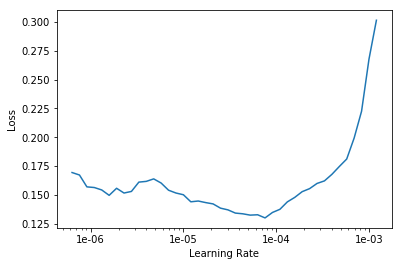

In [16]:
learn.load('guitars-v1-11cl-res34-224px-01')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:20
epoch  train_loss  valid_loss  error_rate
1      0.203661    0.256295    0.074706    (01:15)
2      0.190298    0.167282    0.050000    (01:16)
3      0.112338    0.119913    0.036471    (01:16)
4      0.059014    0.096280    0.027647    (01:16)
5      0.033305    0.091823    0.026471    (01:16)



In [18]:
learn.save('guitars-v1-11cl-res34-224px-02')

## Checking the model status

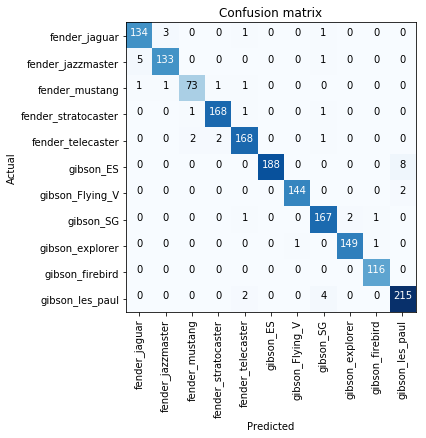

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [20]:
display(interp.most_confused(min_val=2))

[('gibson_ES', 'gibson_les_paul', 8),
 ('fender_jazzmaster', 'fender_jaguar', 5),
 ('gibson_les_paul', 'gibson_SG', 4),
 ('fender_jaguar', 'fender_jazzmaster', 3)]

Ok, this already quite amazing. We are at ~97.2% accuracy. Seems the model has a hard time differentiating between a Jaguar and Jazzmaster (who wouldn't they are super similar). Dito for the Gibson ES and Les Paul (here, special models exist lend features from the other model).

## Let's level up: ResNet 50
Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [21]:
data = get_data(src, sz=224, bs=32)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


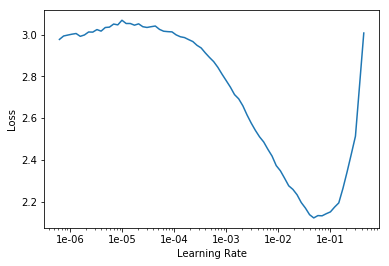

In [22]:
learn = create_cnn(data, models.resnet50, path='.', metrics=error_rate)
learn.freeze()
learn.lr_find(); 
learn.recorder.plot()

In [23]:
lr = 0.01

In [24]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:28
epoch  train_loss  valid_loss  error_rate
1      0.591651    0.319690    0.105294    (02:11)
2      0.461109    0.398586    0.115294    (02:04)
3      0.292784    0.192599    0.067647    (02:04)
4      0.178708    0.128503    0.041176    (02:04)
5      0.098652    0.102441    0.033529    (02:03)



In [25]:
learn.save('guitars-v1-11cl-res50-224px-01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


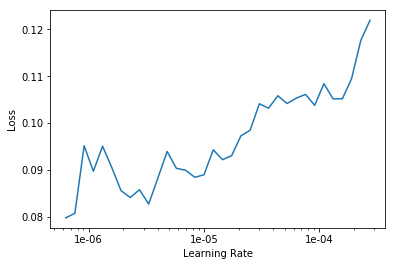

In [26]:
learn.load('guitars-v1-11cl-res50-224px-01')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

Total time: 13:47
epoch  train_loss  valid_loss  error_rate
1      0.122527    0.123221    0.032353    (02:46)
2      0.131352    0.129197    0.040588    (02:45)
3      0.084470    0.085018    0.028235    (02:45)
4      0.055003    0.071305    0.022353    (02:45)
5      0.035648    0.065091    0.020000    (02:45)



In [28]:
learn.save('guitars-v1-11cl-res50-224px-02')

## Progressive Resizing (224 > 448)

In [29]:
learn.load('guitars-v1-11cl-res50-224px-02')
learn.data = get_data(src, sz=448, bs=16)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


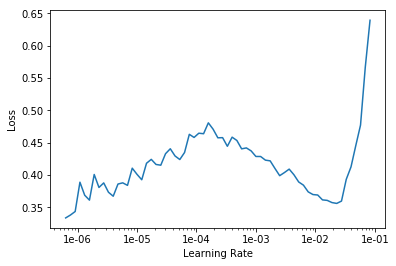

In [30]:
learn.lr_find(); 
learn.recorder.plot()

In [31]:
lr=1e-3

In [32]:
learn.fit_one_cycle(5, slice(lr))

Total time: 37:46
epoch  train_loss  valid_loss  error_rate
1      0.183134    0.086426    0.028235    (07:42)
2      0.099537    0.067973    0.020588    (07:30)
3      0.091131    0.060259    0.015294    (07:31)
4      0.062417    0.050117    0.013529    (07:30)
5      0.049533    0.048065    0.013529    (07:31)



In [33]:
learn.save('guitars-v1-11cl-res50-448px-01')

In [34]:
learn.load('guitars-v1-11cl-res50-448px-01')
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-06, lr/5))

Total time: 49:52
epoch  train_loss  valid_loss  error_rate
1      0.067349    0.044458    0.015294    (10:02)
2      0.055378    0.056939    0.015294    (09:57)
3      0.050544    0.045030    0.011765    (09:57)
4      0.034476    0.040948    0.012353    (09:57)
5      0.032105    0.041326    0.011765    (09:57)



In [35]:
learn.save('guitars-v1-11cl-res50-448px-02')

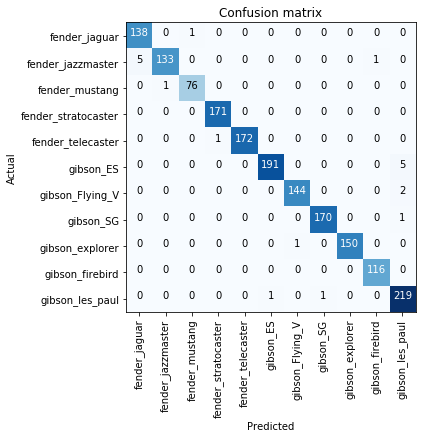

In [36]:
learn.load('guitars-v1-11cl-res50-448px-02')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [37]:
interp.most_confused()

[('fender_jazzmaster', 'fender_jaguar', 5),
 ('gibson_ES', 'gibson_les_paul', 5),
 ('gibson_Flying_V', 'gibson_les_paul', 2)]

Done! 